In [2]:
%load_ext autoreload
%autoreload 2
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PMIX_MCA_gds"]="hash"

# Import useful packages
import qiskit_metal as metal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs

# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

# Packages for the simple design
from SQDMetal.Comps.Junctions import JunctionDolan
import shapely
from SQDMetal.Comps.Polygons import PolyShapely, PolyRectangle
from SQDMetal.Comps.Joints import Joint


# Set up chip design as planar, multiplanar also available
design = designs.DesignPlanar({}, overwrite_enabled=True)

# Set up chip dimensions 
design.chips.main.size.size_x = '800um'
design.chips.main.size.size_y = '800um'
design.chips.main.size.size_z = '500um'
design.chips.main.size.center_x = '0mm'
design.chips.main.size.center_y = '0mm'

JunctionDolan(design, 'junction', options=Dict(pos_x=0, pos_y='-12um', end_x=0, end_y='12um',
                                                         layer=2,
                                                         finger_width='0.4um', t_pad_size='0.385um',
                                                         squid_width='5.4um', prong_width='0.9um'));

#Units in mm...
padCoordNums = [0.19971691, 0.02, 0.17926553, 0.25, 0.25]
padCoords = [[-0.05, 0.012], [0.05, 0.012], [padCoordNums[0], padCoordNums[1]], [padCoordNums[2], padCoordNums[3]], [0, padCoordNums[4]], [-padCoordNums[2], padCoordNums[3]], [-padCoordNums[0], padCoordNums[1]]]
padCoords2 = [[x[0],-x[1]] for x in padCoords][::-1]

poly1 = shapely.Polygon(padCoords).buffer(-0.04, join_style=1, quad_segs=4).buffer(0.04, join_style=1, quad_segs=4)
poly2 = shapely.Polygon(padCoords2).buffer(-0.04, join_style=1, quad_segs=4).buffer(0.04, join_style=1, quad_segs=4)

PolyShapely(design, 'pad1', options=dict(strShapely=poly1.__str__()))
PolyShapely(design, 'pad2', options=dict(strShapely=poly2.__str__()))

PolyRectangle(design, 'rectGnd', options=dict(pos_x='-300um',pos_y='-300um', end_x='300um',end_y='300um', is_ground_cutout=True))

Joint(design, 'j1', options=dict(pos_x='0um', pos_y='-300um'))
Joint(design, 'j2', options=dict(pos_x='0um', pos_y='300um'));

# rebuild the GUI
# gui = MetalGUI(design)
# gui.rebuild()

In [4]:
import shapely

poly1.contains(shapely.Point(0,50e-3))

True

Eigenfrequency at 8.0333GHz

In [5]:
from SQDMetal.COMSOL.Model import COMSOL_Model
from SQDMetal.COMSOL.SimCapacitance import COMSOL_Simulation_CapMats
from SQDMetal.COMSOL.SimRFsParameter import COMSOL_Simulation_RFsParameters

from SQDMetal.Utilities.ShapelyEx import ShapelyEx


#Initialise the COMSOL engine (needs to only be run once)
COMSOL_Model.init_engine()

#Instantiate a COMSOL model
cmsl = COMSOL_Model('leModel')

#Create simulations to setup - in this case capacitance matrix and RF s-parameter
sim_sParams = COMSOL_Simulation_RFsParameters(cmsl, adaptive='None')

#(A) - Initialise model from Qiskit-Metal design object: design
cmsl.initialize_model(design, [sim_sParams], bottom_grounded=True)

cmsl.add_metallic(1, threshold=1e-12, fuse_threshold=1e-10)
cmsl.add_ground_plane()
cmsl.fuse_all_metals()

sim_sParams.create_port_JosephsonJunction('junction', L_J=4.3e-9, C_J=10e-15)

# sim_sParams.add_surface_current_source_region("dielectric", 0.5)
# sim_sParams.add_surface_current_source_region("metals", 10e-6, 2)

# edp_pts = ShapelyEx.get_points_uniform_in_polygon(poly1, 0.01,0.01)
# for cur_pt in edp_pts:
#     x, y = cur_pt[0]*0.001, cur_pt[1]*0.001 #Converting from mm to m
#     sim_sParams.add_electric_point_dipole([x,y, 1e-6], 1, [0,0,1])

cmsl.build_geom_mater_elec_mesh(skip_meshing=True, mesh_structure='Fine')

sim_sParams.set_freq_values([8.118e9])
# cmsl.plot()


cmsl.save('TestPts')

So use 8.033GHz, offset the geometry and excite/measure along y-axis. The excitation is 10um above the JJ...

In [6]:
from SQDMetal.COMSOL.Model import COMSOL_Model
from SQDMetal.COMSOL.SimCapacitance import COMSOL_Simulation_CapMats
from SQDMetal.COMSOL.SimRFsParameter import COMSOL_Simulation_RFsParameters

from SQDMetal.Utilities.ShapelyEx import ShapelyEx


#Initialise the COMSOL engine (needs to only be run once)
COMSOL_Model.init_engine()

results = []
offset_vals = np.linspace(-0.05,0.05,21)
for val in (offset_vals+0.19971691):
    padCoordNums = [val, 0.02, 0.17926553, 0.25, 0.25]
    padCoords = [[-0.05, 0.012], [0.05, 0.012], [padCoordNums[0], padCoordNums[1]], [padCoordNums[2], padCoordNums[3]], [0, padCoordNums[4]], [-padCoordNums[2], padCoordNums[3]], [-padCoordNums[0], padCoordNums[1]]]
    padCoords2 = [[x[0],-x[1]] for x in padCoords][::-1]

    poly1 = shapely.Polygon(padCoords).buffer(-0.04, join_style=1, quad_segs=4).buffer(0.04, join_style=1, quad_segs=4)
    poly2 = shapely.Polygon(padCoords2).buffer(-0.04, join_style=1, quad_segs=4).buffer(0.04, join_style=1, quad_segs=4)

    PolyShapely(design, 'pad1', options=dict(strShapely=poly1.__str__()))
    PolyShapely(design, 'pad2', options=dict(strShapely=poly2.__str__()))

    design.rebuild()

    #Instantiate a COMSOL model
    cmsl = COMSOL_Model('leModel')

    #Create simulations to setup - in this case capacitance matrix and RF s-parameter
    sim_sParams = COMSOL_Simulation_RFsParameters(cmsl, adaptive='None')

    #(A) - Initialise model from Qiskit-Metal design object: design
    cmsl.initialize_model(design, [sim_sParams], bottom_grounded=True)

    cmsl.add_metallic(1, threshold=1e-12, fuse_threshold=1e-10)
    cmsl.add_ground_plane()
    cmsl.fuse_all_metals()

    sim_sParams.create_port_JosephsonJunction('junction', L_J=4.3e-9, C_J=10e-15, R_J=10e3)

    # sim_sParams.add_surface_current_source_region("dielectric", 0.5)
    # sim_sParams.add_surface_current_source_region("metals", 10e-6, 2)

    # edp_pts = ShapelyEx.get_points_uniform_in_polygon(poly1, 0.01,0.01)
    # for cur_pt in edp_pts:
    #     x, y = cur_pt[0]*0.001, cur_pt[1]*0.001 #Converting from mm to m
    #     sim_sParams.add_electric_point_dipole([x,y, 1e-6], 1, [0,0,1])

    sim_sParams.add_electric_point_dipole([0,0, 100e-6], 1, [0,1,0])
    # sim_sParams.add_electric_point_dipole([0,0,0], 0, [0,1,0])

    cmsl.fine_mesh_around_comp_boundaries(['pad1', 'pad2'], minElementSize=10e-6, maxElementSize=50e-6)

    cmsl.build_geom_mater_elec_mesh(skip_meshing=True, mesh_structure='Fine')

    sim_sParams.set_freq_values([8.0333e9])
    # cmsl.plot()
    sim_sParams.run()
    results.append(sim_sParams.eval_field_at_pts('E', np.array([[0,0,0]])))
    # cmsl.save('TestPts')
results = np.array(results)[:,0,:]

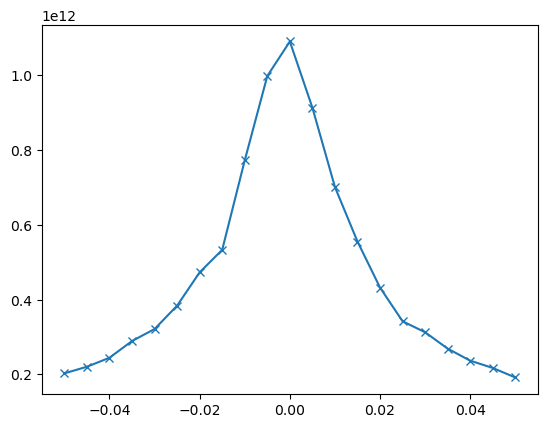

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

# plt.plot(offset_vals, np.abs(results[:,0]), 'x-')
plt.plot(offset_vals, np.abs(results[:,1]), 'x-')

Okay let's try an adjoint simulation

In [8]:
from SQDMetal.COMSOL.Model import COMSOL_Model
from SQDMetal.COMSOL.SimCapacitance import COMSOL_Simulation_CapMats
from SQDMetal.COMSOL.SimRFsParameter import COMSOL_Simulation_RFsParameters

from SQDMetal.Utilities.ShapelyEx import ShapelyEx


#Initialise the COMSOL engine (needs to only be run once)
COMSOL_Model.init_engine()

def gen_geom(val):
    padCoordNums = [val, 0.02, 0.17926553, 0.25, 0.25]
    padCoords = [[-0.05, 0.012], [0.05, 0.012], [padCoordNums[0], padCoordNums[1]], [padCoordNums[2], padCoordNums[3]], [0, padCoordNums[4]], [-padCoordNums[2], padCoordNums[3]], [-padCoordNums[0], padCoordNums[1]]]
    padCoords2 = [[x[0],-x[1]] for x in padCoords][::-1]

    poly1 = shapely.Polygon(padCoords).buffer(-0.04, join_style=1, quad_segs=4).buffer(0.04, join_style=1, quad_segs=4)
    poly2 = shapely.Polygon(padCoords2).buffer(-0.04, join_style=1, quad_segs=4).buffer(0.04, join_style=1, quad_segs=4)

    return poly1, poly2

raw_field_at_JJ = []
raw_field_data = []
adjoint_field_data = []
poly_grads = []
offset_vals = np.linspace(-0.05,0.05,21)
for val in (offset_vals+0.19971691):
    poly1, poly2 = gen_geom(val)
    poly_orig = shapely.MultiPolygon([poly1,poly2])

    PolyShapely(design, 'pad1', options=dict(strShapely=poly1.__str__()))
    PolyShapely(design, 'pad2', options=dict(strShapely=poly2.__str__()))

    design.rebuild()

    #Instantiate a COMSOL model
    cmsl = COMSOL_Model('leModel')
    sim_sParams = COMSOL_Simulation_RFsParameters(cmsl, adaptive='None')
    cmsl.initialize_model(design, [sim_sParams], bottom_grounded=True)
    cmsl.add_metallic(1, threshold=1e-12, fuse_threshold=1e-10)
    cmsl.add_ground_plane()
    cmsl.fuse_all_metals()
    sim_sParams.create_port_JosephsonJunction('junction', L_J=4.3e-9, C_J=10e-15, R_J=10e3)
    sim_sParams.add_electric_point_dipole([0,0, 100e-6], 1, [0,1,0])
    cmsl.fine_mesh_around_comp_boundaries(['pad1', 'pad2'], minElementSize=10e-6, maxElementSize=50e-6)
    cmsl.build_geom_mater_elec_mesh(skip_meshing=True, mesh_structure='Fine')
    sim_sParams.set_freq_values([8.0333e9])
    sim_sParams.run()
    
    raw_field_data.append(sim_sParams.eval_fields_over_mesh())
    raw_field_at_JJ.append(sim_sParams.eval_field_at_pts('E', np.array([[0,0,0]])))

    #Run Adjoint simulation (this is a really bad way to calculate gradients...)
    poly1, poly2 = gen_geom(val+0.001)
    poly_new = shapely.MultiPolygon([poly1,poly2])
    poly_grad = shapely.difference(poly_new, poly_orig)
    #print(type(poly_grad))
    poly_grads.append(poly_grad)
    #
    adjoint_strength = 2*np.real(raw_field_at_JJ[-1][0,1])/(2*np.pi*8.0333e9*1.256637e-6)
    #
    cmsl = COMSOL_Model('leModel')
    sim_sParams = COMSOL_Simulation_RFsParameters(cmsl, adaptive='None')
    cmsl.initialize_model(design, [sim_sParams], bottom_grounded=True)
    cmsl.add_metallic(1, threshold=1e-12, fuse_threshold=1e-10)
    cmsl.add_ground_plane()
    cmsl.fuse_all_metals()
    sim_sParams.create_port_JosephsonJunction('junction', L_J=4.3e-9, C_J=10e-15, R_J=10e3)
    sim_sParams.add_electric_point_dipole([0,0, 1e-6], adjoint_strength, [0,1,0])
    cmsl.fine_mesh_around_comp_boundaries(['pad1', 'pad2'], minElementSize=10e-6, maxElementSize=50e-6)
    cmsl.build_geom_mater_elec_mesh(skip_meshing=True, mesh_structure='Fine')
    sim_sParams.set_freq_values([8.0333e9])
    sim_sParams.run()
    # COMSOL_Model.close_all_models()
    #
    print(print(type(coords), coords.shape, coords.dtype))
    adjoint_field_data.append(sim_sParams.eval_field_at_pts('E', raw_field_data[-1]['coords']))

raw_field_at_JJ = np.array(raw_field_at_JJ)[:,0,:]

NameError: name 'coords' is not defined

In [ ]:
def calc_grad(point, poly_grad):
    point = np.real(point)
    dist = np.sqrt( shapely.distance(shapely.Point([point[0],point[1]]), poly_grad)**2 + point[2]**2 )
    return np.exp(-0.5*(dist/0.002)**2)

dg = []
for m,val in enumerate(offset_vals):
    cur_init_field_data = raw_field_data[m]
    
    Ap_x = cur_init_field_data['E']
    for mesh_coord in cur_init_field_data['coords']:
        Ap_x[m] *= calc_grad(mesh_coord, poly_grads[m])
    
    v_Ap_x = np.dot(np.ndarray.flatten(adjoint_field_data[m]), np.ndarray.flatten(Ap_x))
    dg.append(v_Ap_x)


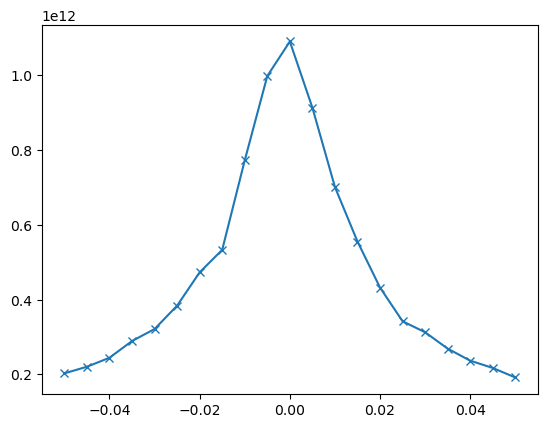

In [ ]:
plt.plot(offset_vals, np.abs(raw_field_at_JJ[:,1]), 'x-')

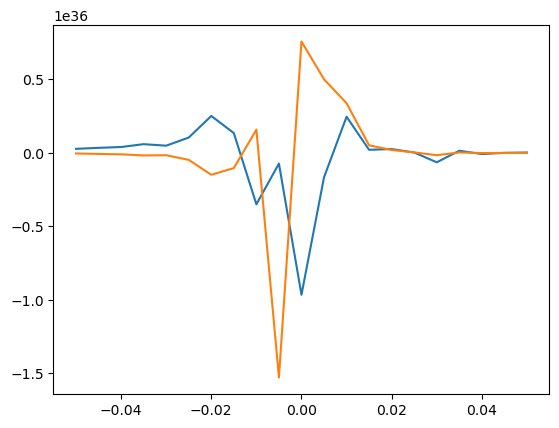

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

dg = np.array(dg)

plt.plot(offset_vals, np.real(dg))
plt.plot(offset_vals, np.imag(dg))

In [ ]:
adjoint_field_data[-1].shape

(46844, 3)